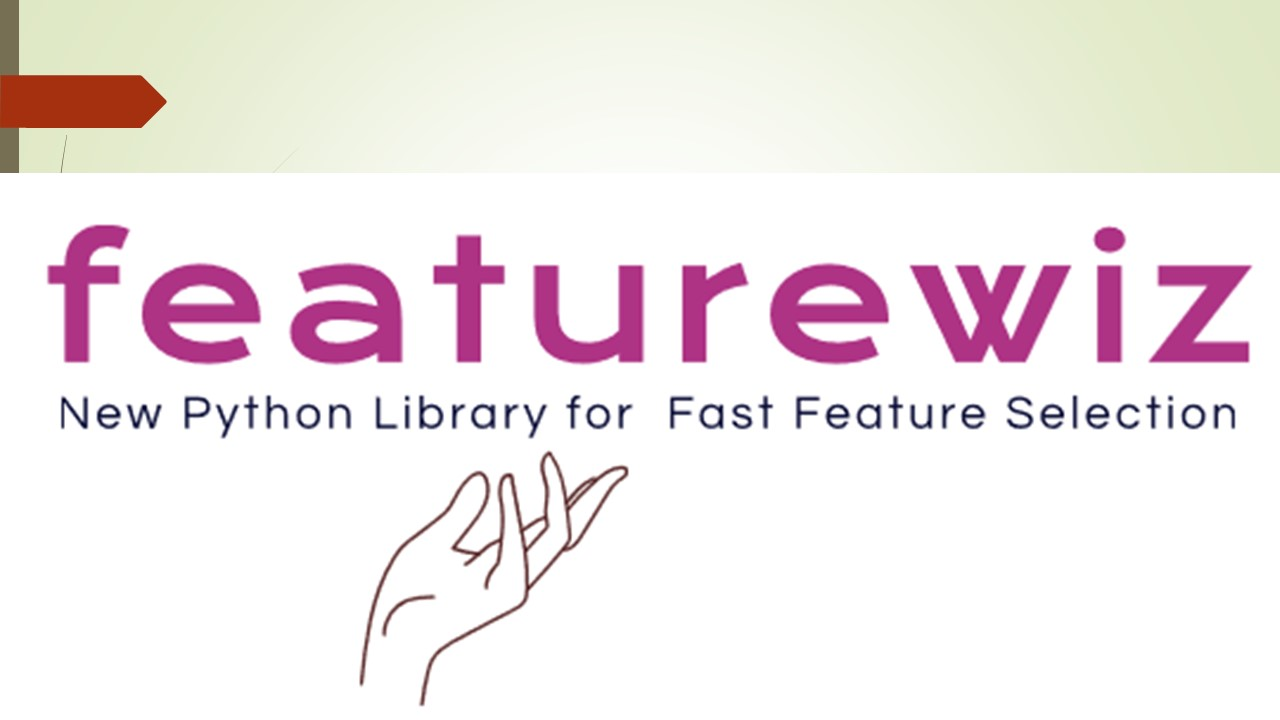

# What is featurewiz?
featurewiz is a new python library  to find the best features in your dataset if you give it the dataframe and the name of the target variable. It will do the following:
1. Remove highly correlated features automatically (the limit is set to 0.70 but you can change it in the input argument)
2. If multiple features are correlated to each other, which one to remove? In case of such clashes, it will remove the feature with the lower mutual information score
3. Recursively do feature selection using XGBoost algorithm to find the best features using XGBoost

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
datapath = '/kaggle/input/credit-card-customers/'
filename = 'BankChurners.csv'

In [ ]:
df = pd.read_csv(datapath+filename)
df = df[df.columns[:-2]]
df = df.sample(frac=1.0, random_state=99)
print(df.shape)
df.head()

# You can install featurewiz two ways:
1. It is available as a Utility Script in Kaggle Notebooks. Just go to File Menu on top and select "Add Utility Script" and find the "featurewiz" script from the list of scripts available in Kaggle.
## In the above case, you will need to use "from featurewiz_py import featurewiz" since Kaggle names the script as featurewiz_py
2. The second method is to "pip install featurewiz" and use it below 

### Use install method if Kaggle allows internet access during a competition.

In [ ]:
#!pip install featurewiz

In [ ]:
from featurewiz import featurewiz

In [ ]:
target = 'Attrition_Flag'

In [ ]:
feats = featurewiz(df, target, corr_limit=0.7, verbose=0)
len(feats)

## So featurewiz selects 15 variables as worth using in a model. 
Let's see how the 15 features compares to the full 21 features that are in the data set

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#RFC = RandomForestRegressor(n_estimators=200, bootstrap=True,
RFC = RandomForestClassifier(n_estimators=200, bootstrap=True,
                            oob_score=True, random_state=43)

In [ ]:
preds = [x for x in list(df) if x not in [target]]
len(preds)

In [ ]:
from featurewiz import convert_all_object_columns_to_numeric
dfx,_ = convert_all_object_columns_to_numeric(df)
dfx.head()

In [ ]:
X = dfx[preds]
y_map = {'Existing Customer':0,'Attrited Customer':1}
y = df[target].map(y_map).values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=99)
print(X_train.shape, y_train.shape)


In [ ]:
X_train.head()

In [ ]:
from sklearn.model_selection import cross_val_score
full = cross_val_score(RFC, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1, verbose=0)
print('Average Cross Validation Accuracy using full set of variables = %0.1f%%' %(
                        np.mean(full)*100))

In [ ]:
from sklearn.metrics import balanced_accuracy_score
print('Balanced Accuracy on Held out Test Data:%0.1f%%' %(100*balanced_accuracy_score(y_test,RFC.fit(X_train,y_train).predict(X_test))))

# Let's compare it to 15 variables from featurewiz

In [ ]:
#### Featurewiz returns the list of variables in the first part of it output
feats[0]

In [ ]:
X = dfx[feats[0]]
y_map = {'Existing Customer':0,'Attrited Customer':1}
y = df[target].map(y_map).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=99)
print(X_train.shape, y_train.shape)

In [ ]:
reduced = cross_val_score(RFC, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1, verbose=0)
print('Average Cross Validation Accuracy using reduced set of variables = %0.1f%%' %(
                        np.mean(reduced)*100))

# So with 30% fewer variables, you are able to achieve close to full-set accuracy. 

In [ ]:
from sklearn.metrics import balanced_accuracy_score
print('Balanced Accuracy on Held out Test Data:%0.1f%%' %(100*balanced_accuracy_score(y_test,RFC.fit(X_train,y_train).predict(X_test))))

# Remember that your test results can be improved by using more complex models or even better, simpler models with good hyper-parameter selection. That way you not only have fewer features but simpler models which means they are much more interpretable to managers and clients!